In [1]:
try:
    import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
try:
    import tqdm
except ModuleNotFoundError:
    !pip install tqdm
try:
    import pydicom
except ModuleNotFoundError:
    !pip install pydicom

from fastkaggle import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.data.all import *
from tqdm.notebook import tqdm
import pydicom
from PIL import Image

/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [2]:
comp = "rsna-pneumonia-detection-challenge"
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

## Classification

In [3]:
train_path = Path("data")
bs = 64
epochs = 8
# arch = 'convnext_tiny.fb_in22k'
# arch = 'resnet26d'
arch = 'resnet50'

In [4]:
labels = pd.read_csv(path/"stage_2_train_labels.csv")
labels = labels.drop_duplicates("patientId")
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

# Preprocess

In [5]:
if not os.path.exists(train_path):
    os.makedirs(train_path)
    os.makedirs(train_path/"0")
    os.makedirs(train_path/"1")

# Only process if no files in folder
files = get_image_files(train_path)
if len(files) == 0:
    for c, patient_id in enumerate(tqdm(labels.patientId)):
        label = labels.Target.iloc[c]
        dcm = pydicom.read_file(path/f"stage_2_train_images/{patient_id}.dcm").pixel_array #/ 255
        # dcm = cv2.resize(dcm, (224, 224))#.astype(np.float16)
        img = Image.fromarray(dcm).convert("L")
        if label == 0:
            img.save(train_path/f"Negative/{patient_id}.jpg")
        elif label == 1:
            img.save(train_path/f"Positive/{patient_id}.jpg")

files = get_image_files(train_path)

In [6]:
dls = ImageDataLoaders.from_folder(train_path, 
                                   valid_pct=0.2,
                                   item_tfms=Resize(192),
                                   batch_tfms=aug_transforms(size=128, min_scale=0.75))

21348

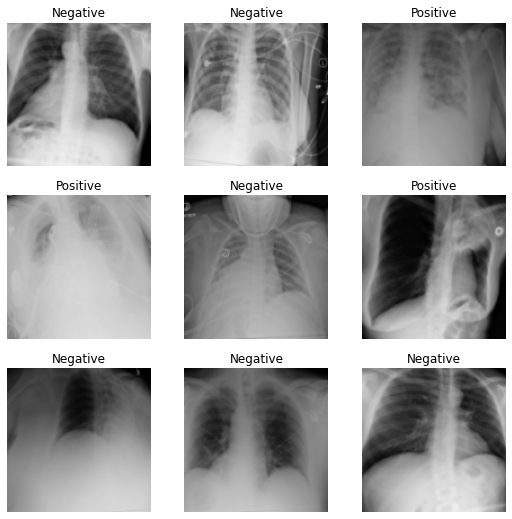

In [7]:
dls.show_batch()
len(dls.train_ds)

In [8]:
learn = vision_learner(dls, arch, metrics=error_rate, path='.').to_fp16() 

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


SuggestedLRs(valley=0.005248074419796467, slide=0.0063095735386013985)

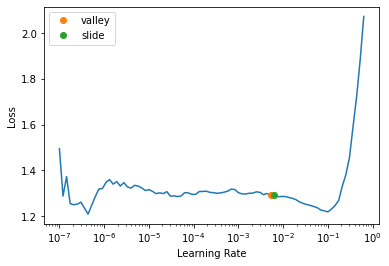

In [9]:
learn.lr_find(suggest_funcs=(valley, slide))

In [10]:
learn.fine_tune(epochs=epochs, base_lr=0.01)

In [11]:
learn.export('models/model.pkl')

In [12]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.1629)

              precision    recall  f1-score   support

    Negative       0.85      0.96      0.90      4190
    Positive       0.70      0.37      0.49      1146

    accuracy                           0.83      5336
   macro avg       0.77      0.66      0.69      5336
weighted avg       0.82      0.83      0.81      5336



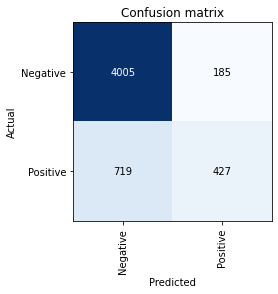

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

## Detection

## Submission

Write .csv in following format:

patientId,PredictionString  
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.5 0 0 100 100  
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,  
00322d4d-1c29-4943-afc9-b6754be640eb,0.8 10 10 50 50 0.75 100 100 5 5

Sort file names

In [14]:
# import csv

# example data
data = [
    ['0004cfab-14fd-4e49-80ba-63a80b6bddd6', '0.5 0 0 100 100'],
    ['00313ee0-9eaa-42f4-b0ab-c148ed3241cd', ''],
    ['00322d4d-1c29-4943-afc9-b6754be640eb', '0.8 10 10 50 50 0.75 100 100 5 5']
]

# write data to CSV file
with open('predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['patientId', 'PredictionString'])
    for row in data:
        writer.writerow(row)